## Code adapted from fast.ai DL1 Course

In [1]:
import sys
import os
import subprocess

from six import string_types

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
%matplotlib inline

In [2]:
! ls -lha ../dl1/data/planet/

total 3.7G
drwxrwxr-x 5 paperspace paperspace 4.0K Jul  9 17:59 .
drwxrwxr-x 7 paperspace paperspace 4.0K Jul  5 12:57 ..
-rw-rw-r-- 1 paperspace paperspace 8.3K Jul  6 22:30 Kaggle-planet-test-tif.torrent
-rw-rw-r-- 1 paperspace paperspace 8.3K Jul  6 22:29 Kaggle-planet-train-tif.torrent
-rw-rw-r-- 1 paperspace paperspace 2.8M Jul  9 17:50 sample_submission_v2.csv
drwxrwxr-x 2 paperspace paperspace 1.3M Apr 19  2017 test-jpg
drwxrwxr-x 2 paperspace paperspace 700K May  4  2017 test-jpg-additional
-rw-rw-r-- 1 paperspace paperspace 322M May  6  2017 test-jpg-additional.tar
-rw-rw-r-- 1 paperspace paperspace 304M Jul  9 17:56 test-jpg-additional.tar.7z
-rw-rw-r-- 1 paperspace paperspace 638M Apr 19  2017 test-jpg.tar
-rw-rw-r-- 1 paperspace paperspace 604M Jul  9 17:00 test-jpg.tar.7z
-rw-rw-r-- 1 paperspace paperspace 604M Jul  9 16:59 test-jpg.tar.7z?dl=0
-rw-rw-r-- 1 paperspace paperspace 600K Jul  9 17:52 test_v2_file_mapping.csv
drwxrwxr-x 2 paperspace paperspace 1.4M Apr 19  2017

In [3]:
!ls -lha ../dl1/data/planet/train-jpg | wc -l

40482


Set PLANET_KAGGLE_ROOT to the proper directory where we have JPG files, and accompanying CSVs

In [4]:
PLANET_KAGGLE_ROOT = os.path.abspath("../dl1/data/planet/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

## Inspect image labels

The labels are in CSV entitled train.csv. Note that each image can be tagged with multiple tags. We'll convert them to a "one hot" style representation where each label is a column.

In [5]:
!ls -lha ../dl1/data/planet/train_v2.csv

-rw-rw-r-- 1 paperspace paperspace 1.4M Jul  9 17:36 ../dl1/data/planet/train_v2.csv


In [6]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
# build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [8]:
# add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

In [9]:
# display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


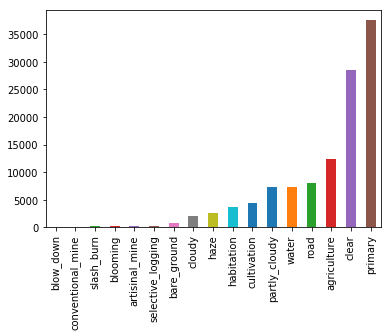

In [10]:
# Histogram of label instances

labels_df[label_list].sum().sort_values().plot.bar()

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


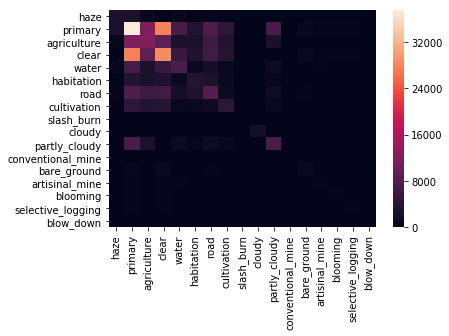

In [11]:
def make_coocurrence_matrix(labels):
    numeric_df = labels_df[labels];
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix

# Compute the co-occurrence matrix
make_coocurrence_matrix(label_list)

Each image should have exactly one weather label:

,clear,partly_cloudy,haze,cloudy
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
haze,0,0,2697,0
cloudy,0,0,0,2089


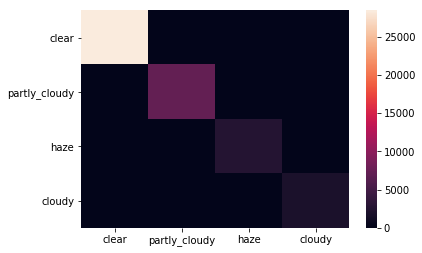

In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_coocurrence_matrix(weather_labels)

But the land labels may overlap:

,primary,agriculture,water,cultivation,habitation
primary,37513,11972,7001,4455,3469
agriculture,11972,12315,2712,3377,2737
water,7001,2712,7411,868,915
cultivation,4455,3377,868,4477,895
habitation,3469,2737,915,895,3660


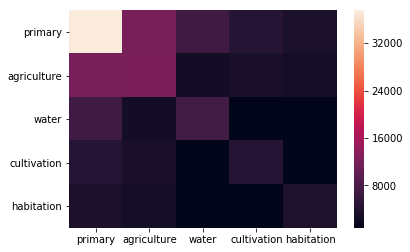

In [13]:
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_coocurrence_matrix(land_labels)

The rarer labels have very little overlap:

,slash_burn,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
slash_burn,209,0,10,0,2,2,2
conventional_mine,0,100,10,4,0,0,0
bare_ground,10,10,862,40,3,13,4
artisinal_mine,0,4,40,339,0,6,0
blooming,2,0,3,0,332,7,1
selective_logging,2,0,13,6,7,340,1
blow_down,2,0,4,0,1,1,98


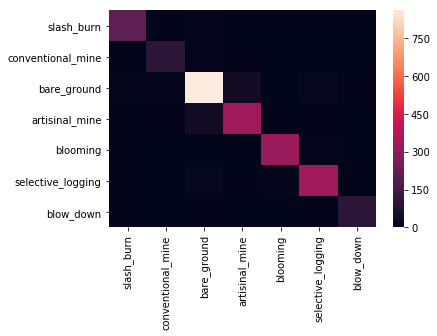

In [14]:
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
make_coocurrence_matrix(rare_labels)

## Inspect images

Let's display an image and visualize the pixel values. Here we will pick an image, load every single single band, then create RGB stack. These raw images are 16-bit (from 0 to 65535), and contain red, green, blue, and Near infrared (NIR) channels. In this example, we are discarding the NIR band just to simplify the steps to visualize the image. However, you should probably keep it for ML classification.

The files can be easily read into numpy arrays with the skimage.

In [17]:
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types):
        raise ValueError("Pass a list of tags, not a single tags.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

In [18]:
def load_image(filename):
    '''Look through the diretory tree to find the image you specified (e.g., train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            print('Found image {}'.format(path))
            return io.imread(path)
    # if you reach this line, you didn't find the image you're looking for
    print('Load failed: could not find image {}'.format(path))

def sample_to_fname(sample_df, row_idx, suffix='jpg'):
    '''Given a dataframe of sampled images, get the corresponding filename.'''
    fname = sample_df.get_value(sample_df.index[row_idx], 'image_name')
    return '{}.{}'.format(fname, suffix)

Let's look at an individual image. First, we'll plot a histogram of pixel values in each channel. Note how the intensities are distributed in a relatively narrow region of the dynamic range.

In [25]:
def plot_rgbn_histo(r, g, b, n):
    for slice_, name, color in ((r, 'r', 'red'), (g, 'g', 'green'), (b, 'b', 'blue'), (nir, 'nir', 'magenta')):
        plt.hist(slice_.ravel(), bins=100,
                range=[0, rgb_image.max()],
                label=name, color=color, histtype='step')
        plt.legend()

Found image /home/paperspace/fastai/courses/dl1/data/planet/train-jpg/train_23615.jpg


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


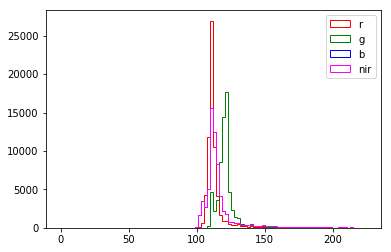

In [40]:
s = sample_images(['primary', 'water', 'road'], n=1)
fname = sample_to_fname(s, 0)

# find the image in the data directory and load it
# note the initial bgrn band ordering
bgrn_image = load_image(fname)

# extract the rgb values
bgr_image = bgrn_image[:,:,:3]
rgb_image = bgr_image[:, :, [2,1,0]]

# extract the different bands
# b, g, r, nir = bgrn_image[:, :, 0], bgrn_image[:, :, 1], bgrn_image[:, :, 2], bgrn_image[:, :, 3]

# faked nir value to be same as r...
b, g, r, nir = bgrn_image[:, :, 0], bgrn_image[:, :, 1], bgrn_image[:, :, 2], bgrn_image[:, :, 0]

# plot a histogram of rgbn values
plot_rgbn_histo(r, g, b, r)

Come back to previuos code as needed!

We can look at each channel individually:

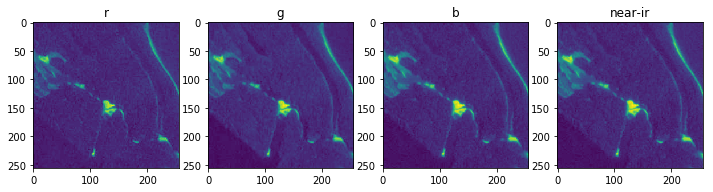

In [41]:
# Plot the bands

fig = plt.figure()
fig.set_size_inches(12, 4)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (nir, 'near-ir'))):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x)

But when we try to look at the RGB image, something funny is going on!

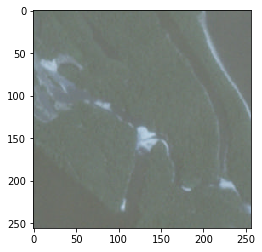

In [42]:
plt.imshow(rgb_image)

## Calibrate colors for visual inspection

Yikes! That does not look pretty. This is not a problem for analytic purposes, but we can try some transformations to make the image look better for visual inspection.

One way of doing this is to the normalize channels to a reference color curve. We'll show here how to estimate a reference color curve from other normalized images. We could choose a third party aerial image of a canopy, but here we will employ the JPEG images provided in the data set, which have already been color-corrected.

In essence, the idea is to transform the pixel values of the test image so that their average and variance match the reference image data.

Get a list of reference images to extract data from:

In [43]:
# Pull a list of 20000 image names
jpg_list = os.listdir(PLANET_KAGGLE_JPEG_DIR)[:20000]

# Select a random sample of 100 among those
np.random.shuffle(jpg_list)
jpg_list = jpg_list[:100]

In [44]:
print(jpg_list)

['train_28519.jpg', 'train_31609.jpg', 'train_6323.jpg', 'train_2127.jpg', 'train_31213.jpg', 'train_5476.jpg', 'train_22032.jpg', 'train_7402.jpg', 'train_23236.jpg', 'train_6733.jpg', 'train_16095.jpg', 'train_14423.jpg', 'train_28799.jpg', 'train_11575.jpg', 'train_32210.jpg', 'train_30100.jpg', 'train_30040.jpg', 'train_38244.jpg', 'train_6025.jpg', 'train_39311.jpg', 'train_13529.jpg', 'train_15043.jpg', 'train_6710.jpg', 'train_21962.jpg', 'train_37763.jpg', 'train_5093.jpg', 'train_23298.jpg', 'train_7994.jpg', 'train_11517.jpg', 'train_21198.jpg', 'train_37266.jpg', 'train_35751.jpg', 'train_19649.jpg', 'train_19301.jpg', 'train_20271.jpg', 'train_11556.jpg', 'train_587.jpg', 'train_34327.jpg', 'train_2189.jpg', 'train_4795.jpg', 'train_40260.jpg', 'train_6127.jpg', 'train_21633.jpg', 'train_32471.jpg', 'train_29332.jpg', 'train_27354.jpg', 'train_3626.jpg', 'train_281.jpg', 'train_34778.jpg', 'train_20446.jpg', 'train_3377.jpg', 'train_14151.jpg', 'train_38891.jpg', 'train_111

Read each image (8-bit RGBA) and dump the pixels values to ref_colors, which contains buckets for R, G, and B

In [45]:
ref_colors = [[],[],[]]
for _file in jpg_list:
    # keep only the first 3 bands, RGB
    _img = mpimg.imread(os.path.join(PLANET_KAGGLE_JPEG_DIR, _file))[:,:,:3]
    # Flatten 2-D to 1-D
    _data = _img.reshape((-1,3))
    # Dump pixel values to aggregation buckets
    for i in range(3):
        ref_colors[i] = ref_colors[i] + _data[:,i].tolist()
        
ref_colors = np.array(ref_colors)

Visualize the histogram of the reference data

Text(0.5,1,'Reference color histograms')

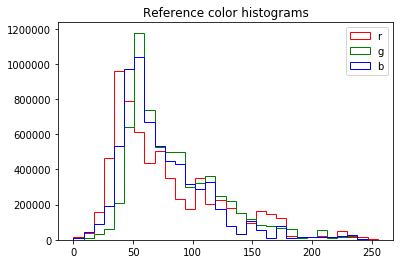

In [46]:
for i, color in enumerate(['r','g','b']):
    plt.hist(ref_colors[i], bins=30, range=[0,255], label=color, color=color, histtype='step')
plt.legend()
plt.title('Reference color histograms')

Compute the mean and variance for each channel in the reference data

In [47]:
ref_means = [np.mean(ref_colors[i]) for i in range(3)]
ref_stds = [np.std(ref_colors[i]) for i in range(3)]

And now, we have a function that can calibrate any raw image reasonably well:

In [48]:
def calibrate_image(rgb_image):
    # Transform test image to 32-bit floats to avoid
    # surprises when doing arithmetic with it
    calibrated_img = rgb_image.copy().astype('float32')
    
    # Loop over RGB
    for i in range(3):
        # Subtract mean
        calibrated_img[:,:,i] = calibrated_img[:,:,i]-np.mean(calibrated_img[:,:,i])
        # Normalize variance
        calibrated_img[:,:,i] = calibrated_img[:,:,i]/np.std(calibrated_img[:,:,i])
        # Scale to reference
        calibrated_img[:,:,i] = calibrated_img[:,:,i]*ref_stds[i] + ref_means[i]
        # CLip any values going out the valid range
        calibrated_img[:,:,i] = np.clip(calibrated_img[:,:,i], 0, 255)
        
    # Convert to 8-bit unsigned int
    return calibrated_img.astype('uint8')

Visualize the color histogram of the newly calibrated test image, and note that it's more evenly distributed throughout the dynamic range, and is closer to the reference data.

Text(0.5,1,'Calibrated image color histograms')

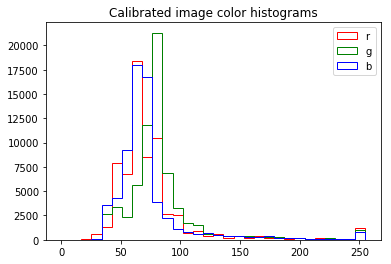

In [49]:
test_image_calibrated = calibrate_image(rgb_image)
for i, color in enumerate(['r', 'g', 'b']):
    plt.hist(test_image_calibrated[:,:,i].ravel(), bins=30, range=[0, 255],
                label=color, color=color, histtype='step')
plt.legend()
plt.title('Calibrated image color histograms')

And now we have something we can recognize!

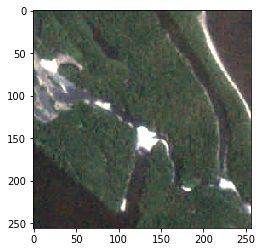

In [50]:
plt.imshow(test_image_calibrated)

Putting it all together, to show several images with your tags of choice.

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


Found image /home/paperspace/fastai/courses/dl1/data/planet/train-jpg/train_30631.jpg
Found image /home/paperspace/fastai/courses/dl1/data/planet/train-jpg/train_39563.jpg
Found image /home/paperspace/fastai/courses/dl1/data/planet/train-jpg/train_31093.jpg


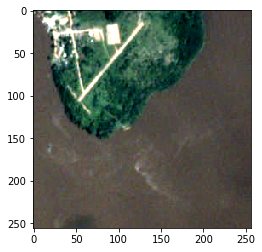

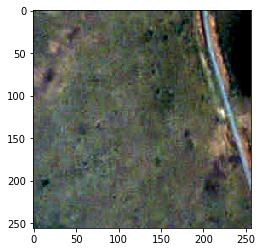

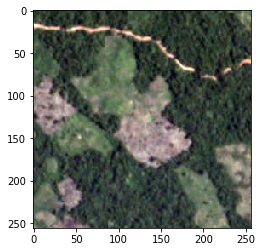

In [51]:
sampled_images = sample_images(['clear', 'road', 'water'], n=3)

for i in range(len(sampled_images)):
    jpg = sample_to_fname(sampled_images, i, 'jpg')
    
    try:
        jpg_img = load_image(jpg)[:,:,:3]
        
        fig = plt.figure()
        plt.imshow(calibrate_image(jpg_img))
        
    except:
        continue

## Image modification

You might want to rotate, flip, or otherwise modify the images for training purposes. Note that the dimensions of the image changes:

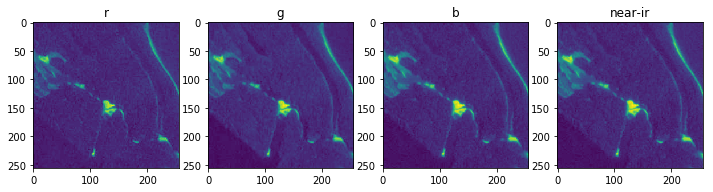

In [52]:
fig = plt.figure()
fig.set_size_inches(12, 4)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (nir, 'near-ir'))):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x)

(362, 362, 3)

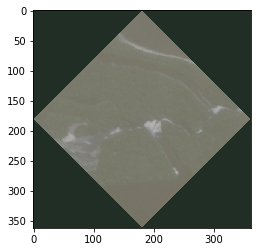

In [53]:
rotated = scipy.ndimage.rotate(rgb_image, angle=45)
plt.imshow(rgb_image)
plt.imshow(calibrate_image(rotated))
rotated.shape